In [11]:
from rfgap import RFGAP
from sklearn.model_selection import train_test_split
from dataset import dataprep


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read in the data and normalize

In [12]:
# TODO: Test with NumPy and Pandas, ALL METHODS and perhaps combos of each type. Problem with categorical data in Pandas?
# We should probably modify RFGAP to handle categorical data in the form of strings.

In [13]:
seed = 42
prox_method = 'rfgap'
force_symmetric = False
non_zero_diagonal = False
max_normalize = False
oob_score = True
verbose=True
test_size=0.2
n_jobs = -1

data = pd.read_csv('/Users/aumona/Projects/RF-GAP-Python/data/iris.csv')
x, y   = dataprep(data)

n_samples = x.shape[0]
n_features = x.shape[1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

print(f"Train samples: {x_train.shape[0]}, Test samples: {x_test.shape[0]}")
print(f"Number of features: {x_train.shape[1]}")

Train samples: 120, Test samples: 30
Number of features: 4


## Train the RF Model

In [14]:
rf = RFGAP(y = y_train, prox_method = prox_method, matrix_type = 'sparse', oob_score = True,
           non_zero_diagonal = non_zero_diagonal, force_symmetric = force_symmetric,
           max_normalize = max_normalize,
           random_state = seed, n_jobs = n_jobs, verbose=verbose)

In [15]:
rf.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


,prox_method,'rfgap'
,matrix_type,'sparse'
,non_zero_diagonal,False
,force_symmetric,False
,max_normalize,False


## Generate the Proximity Matrix

In [16]:
# compute/get proximity matrix and visualize with seaborn heatmap
prox = rf.get_proximities()

# Visualize it

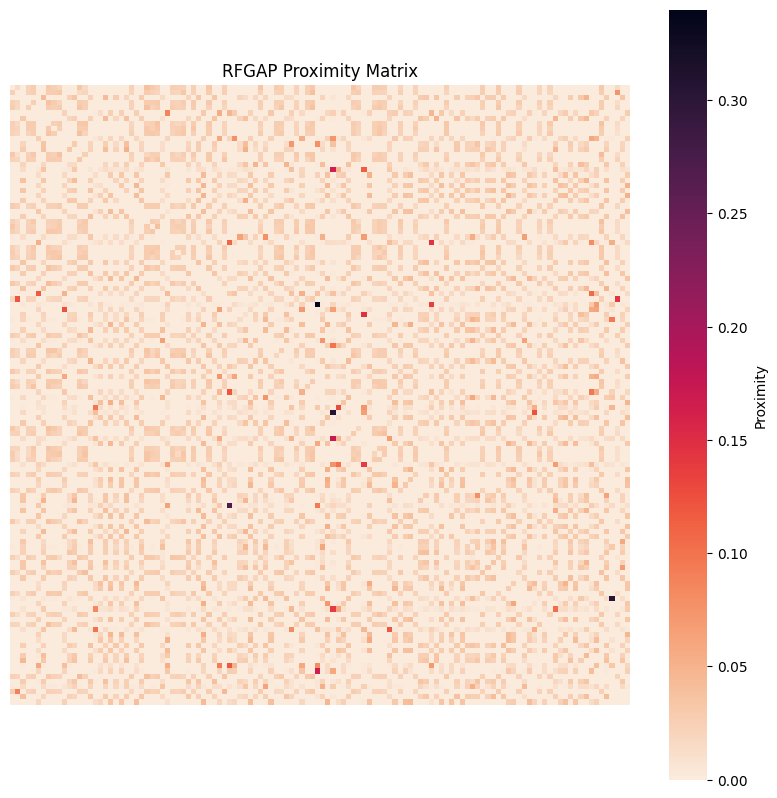

Row sums (should be close to 1):
[1.         1.         1.0000001  1.         0.99999994 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.0000001  1.         1.0000001
 1.0000001  1.         1.         1.0000001  1.0000001  1.
 1.         1.         1.         1.0000001  1.         1.
 1.0000001  1.         1.         0.99999994 1.         1.
 1.         1.         0.9999999  1.         1.         1.
 1.         1.0000001  0.99999994 1.         1.         1.
 1.         1.         0.99999994 1.         0.99999994 0.99999994
 1.0000001  1.         1.         1.0000001  0.99999994 1.
 1.         1.         1.         1.         1.         1.
 1.         1.0000001  1.         0.99999994 0.99999994 1.0000001
 1.         1.         1.         1.0000001  1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.0000001  1.         1.         1.         1.
 1.         1.         1.         1.         0.99999994 1.
 

In [17]:
prox_mat = prox.toarray()

# mask diagonal to emphasize off-diagonal proximities
mask = np.eye(prox_mat.shape[0], dtype=bool)
mask=None

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(prox_mat, ax=ax, cmap='rocket_r', vmin=0, vmax=prox_mat.max(),
            mask=mask,
            xticklabels=False, yticklabels=False, square=True, cbar_kws={'label': 'Proximity'})
ax.set_title(f'{prox_method.upper()} Proximity Matrix')
plt.show()

# Check row sums
row_sums = prox_mat.sum(axis=1)
print("Row sums (should be close to 1):")
print(row_sums)

# Show diagonal values
diag = prox.diagonal()
print("Diagonal values:")
print(diag)

## Check extended proximity computation using a training subset

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


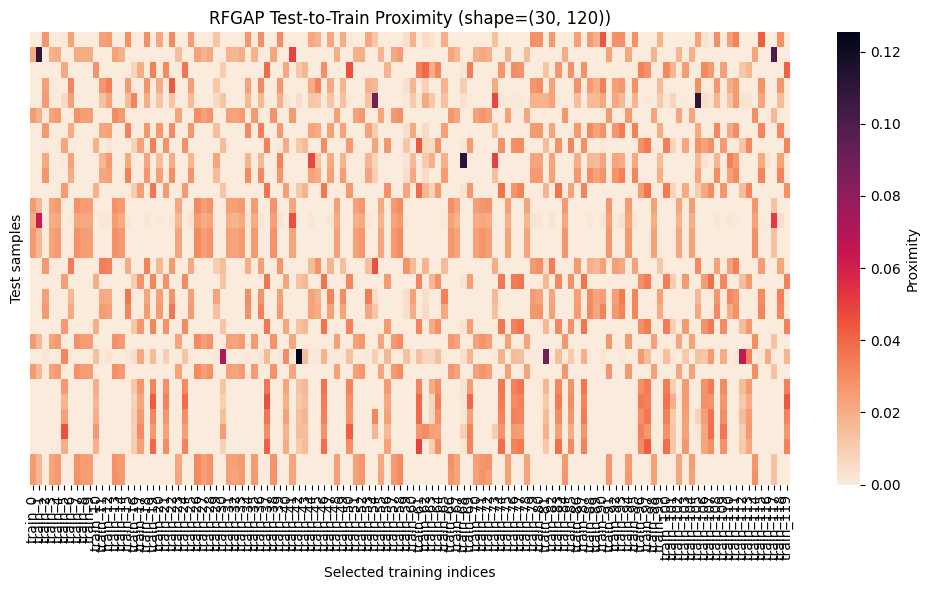

In [18]:
# selected_train_indices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
selected_train_indices = np.arange(x_train.shape[0])
test_prox = rf.prox_extend(x_test).toarray()
# test_prox = rf.prox_extend(x_test).toarray()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(test_prox, ax=ax, cmap='rocket_r', vmin=0, vmax=test_prox.max(),
            xticklabels=[f'train_{i}' for i in selected_train_indices],
            yticklabels=False, cbar_kws={'label': 'Proximity'})
ax.set_xlabel('Selected training indices')
ax.set_ylabel('Test samples')
ax.set_title(f'{prox_method.upper()} Test-to-Train Proximity (shape={test_prox.shape})')
plt.tight_layout()
plt.show()

## Check Sum-to-One

In [19]:
# check row sums (should sum to 1)
row_sums = np.sum(prox.toarray(), axis=1)

print("rows:", row_sums.shape[0])
print("min, max, mean:", row_sums.min(), row_sums.max(), row_sums.mean())

tol_r, tol_a = 1e-5, 1e-8
close_mask = np.isclose(row_sums, 1.0, rtol=tol_r, atol=tol_a)
print(f"rows ~1 within rtol={tol_r}, atol={tol_a}: {np.count_nonzero(close_mask)}/{len(row_sums)}")

bad_idx = np.where(~close_mask)[0]
if bad_idx.size:
    print("Example rows not summing to ~1 (index, sum):")
    for i in bad_idx[:10]:
        print(i, row_sums[i])
else:
    print("All rows sum approximately to 1.")

rows: 120
min, max, mean: 0.9999999 1.0000001 1.0
rows ~1 within rtol=1e-05, atol=1e-08: 120/120
All rows sum approximately to 1.


## Measures of Trust

### RF-ICE (Trust Scores)

In [20]:
ice_scores = rf.get_instance_classification_expectation()
print(rf.trust_auc)

0.9844370268980634


#### Accuracy Rejection Curve

Text(0.5, 1.0, 'Scatter Plot of Training Data with 1 - Trust Scores')

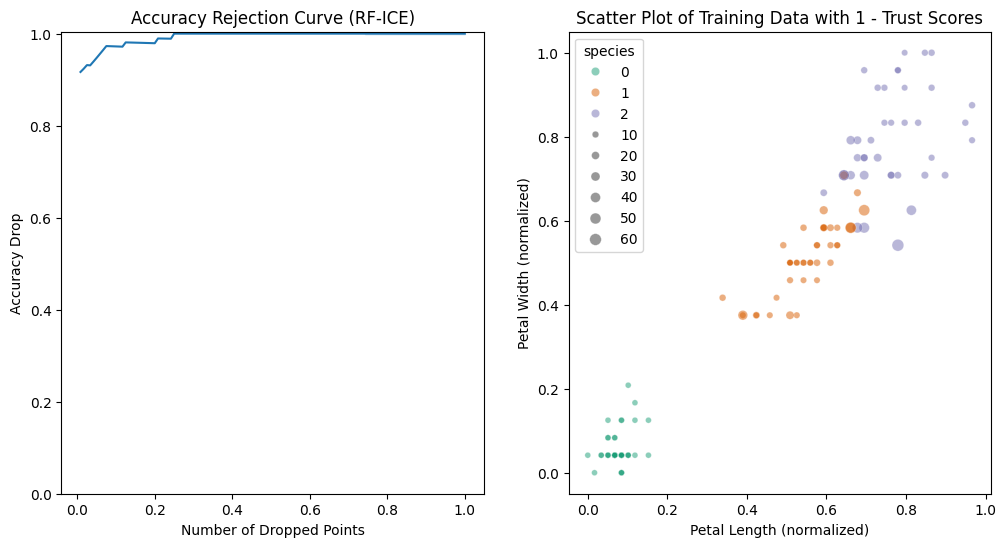

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(x=rf.trust_n_drop, y=rf.trust_accuracy_drop, ax=ax[0])
ax[0].set_xlabel('Number of Dropped Points')
ax[0].set_ylabel('Accuracy Drop')
ax[0].set_title('Accuracy Rejection Curve (RF-ICE)')
ax[0].set_ylim(0, None)

sns.scatterplot(x=x_train[:, 2], y=x_train[:, 3], hue=y_train, palette='Dark2',
                size=(np.max(rf.trust_scores) - rf.trust_scores) * 100 + 5, alpha=0.5, ax=ax[1])
ax[1].set_xlabel('Petal Length (normalized)')
ax[1].set_ylabel('Petal Width (normalized)')
ax[1].set_title('Scatter Plot of Training Data with 1 - Trust Scores')


### RF-ICE for Test Set

In [22]:
trust_scores_test = rf.get_test_trust(x_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


Text(0.5, 1.0, 'Test Data with 1 - Trust Scores')

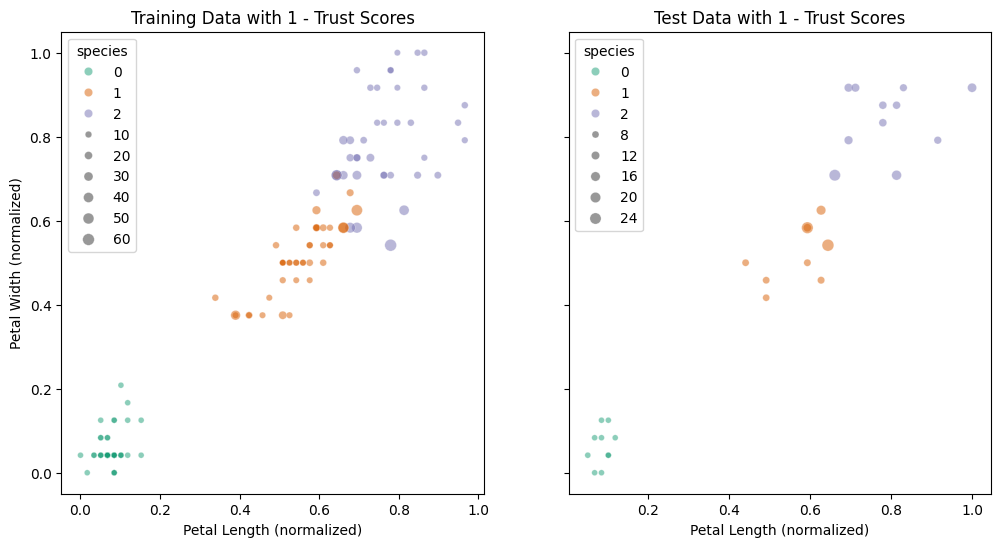

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey = True)

sns.scatterplot(x=x_train[:, 2], y=x_train[:, 3], hue=y_train, palette='Dark2',
                size=(np.max(rf.trust_scores) - rf.trust_scores) * 100 + 5, alpha=0.5, ax=ax[0])
ax[0].set_xlabel('Petal Length (normalized)')
ax[0].set_ylabel('Petal Width (normalized)')
ax[0].set_title('Training Data with 1 - Trust Scores')

sns.scatterplot(x=x_test[:, 2], y=x_test[:, 3], hue=y_test, palette='Dark2',
                size=(np.max(rf.trust_scores_test) - rf.trust_scores_test) * 100 + 5, alpha=0.5, ax=ax[1])
ax[1].set_xlabel('Petal Length (normalized)')
ax[1].set_ylabel('Petal Width (normalized)')
ax[1].set_title('Test Data with 1 - Trust Scores')

In [24]:
rf.get_nonconformity(k = 5, x_test = x_test, proximity_type = 'rfgap')

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [25]:
rf.test_proximities.shape

(30, 120)

Text(0.5, 1.0, 'Scatter Plot of Training Data with Nonconformity Scores')

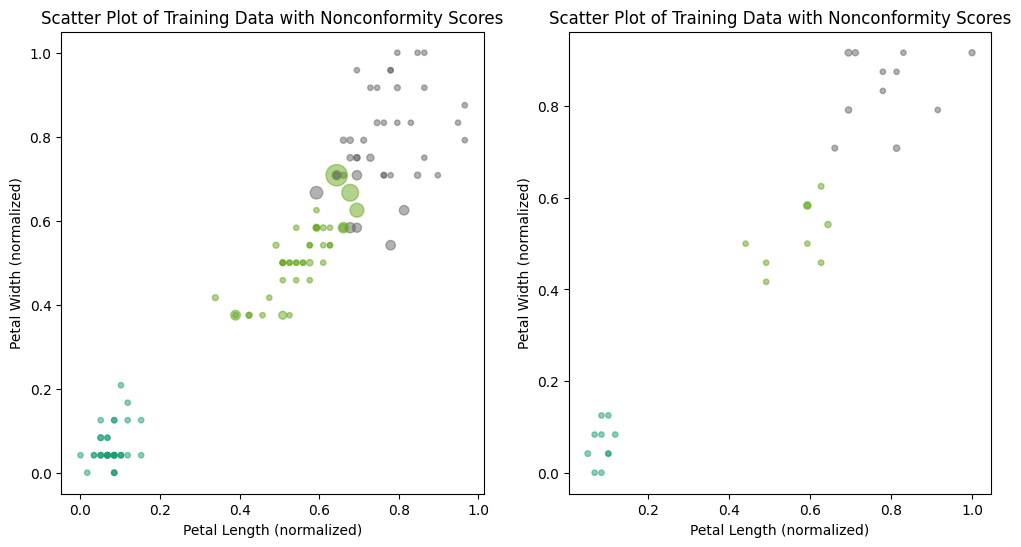

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


ax[0].scatter(x_train[:, 2], x_train[:, 3], c=y_train, cmap='Dark2', 
            s=rf.nonconformity_scores * 20 + 15, alpha=0.5)
ax[0].set_xlabel('Petal Length (normalized)')
ax[0].set_ylabel('Petal Width (normalized)')
ax[0].set_title('Scatter Plot of Training Data with Nonconformity Scores')


ax[1].scatter(x_test[:, 2], x_test[:, 3], c = y_test, cmap='Dark2', 
            s=rf.nonconformity_scores_test * 20 + 15, alpha=0.5)
ax[1].set_xlabel('Petal Length (normalized)')
ax[1].set_ylabel('Petal Width (normalized)')
ax[1].set_title('Scatter Plot of Training Data with Nonconformity Scores')

Text(0.5, 1.0, 'Conformity Accuracy Rejection Curve')

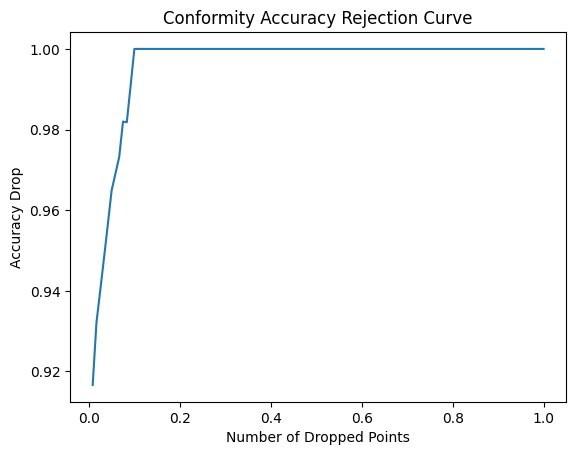

In [27]:
sns.lineplot(x=rf.conformity_n_drop, y=rf.conformity_accuracy_drop)
plt.xlabel('Number of Dropped Points')
plt.ylabel('Accuracy Drop')
plt.title('Conformity Accuracy Rejection Curve')

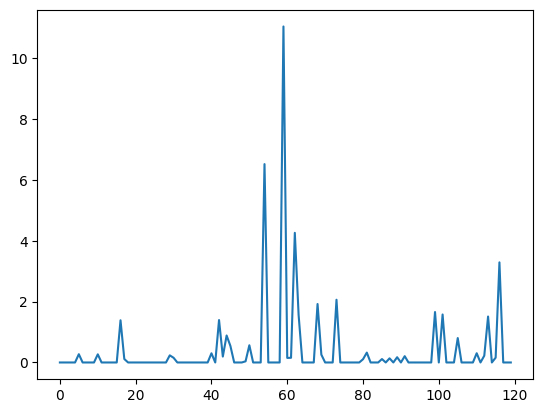

In [28]:
plt.plot(rf.nonconformity_scores)

In [29]:
                # Updates the following attributes:
                # - `self.nonconformity_scores`
                # - `self.conformity_scores`
                # - `self.conformity_quantiles`
                # - `self.conformity_auc`
                # - `self.conformity_accuracy_drop`
                # - `self.conformity_n_drop`
                
                # If `x_test` is provided, also updates:
                # - `self.nonconformity_scores_test`
                # - `self.conformity_scores_test`
                # - `self.conformity_quantiles_test`